## Simulating the effects of varying the MLA-objective separation

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields
from numpy.fft import fft, ifft, fftshift, ifftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


This notebook simulates the effects of varying the distance between the second MLA and the objective's back focal plane.

## Build the coordinate system and dual-MLA's

In [2]:
numLenslets = 21     # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500    # microns
focalLength = 13700  # microns, lenslet focal lengths
fc          = 50000  # microns, collimating lens focal length
dR          = -5000  # microns, distance of diffuser from telescope focus
L1          = 700000 # microns, distance between collimating lens and first MLA
L2          = 200000 # microns, distance between second MLA and objective BFP
wavelength  = 0.642  # microns

subgridSize  = 20001 # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
collGrid = grids.Grid(20001, 5000, wavelength, fc, dim = 1)
grid     = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)

Now, the output from the telescope + diffuser may be generated by multiplying the focused Gaussian beam with a random phase mask from the Voelz code.

The input beam has a 4 mm waist (radius), but is focused by a telescope whose first lens has a focal length of 100 mm = 1e5 microns. [Using a Gaussian beam calculator](http://www.calctool.org/CALC/phys/optics/f_NA), this means that the focused beam has a waist diameter of \\( 2w = 10.2 \, \mu m \\) and a beam standard deviation of \\( \frac{5.1 \mu m}{\sqrt{2}} = 3.6 \mu m \\). The measured beam standard deviation in the setup is in reality about \\( 6.0 \, \mu m \\) due to a slight astigmatism in the beam beam and spherical aberration. (The telescope lenses are simple plano-convex lenses.)

After multiplying the beam by the phase screen, the field is Fourier transformed by the second telescope lens with \\( f = 50 \, mm \\) to produce the field in the focal plane of the collimating lens. The following steps are then taken to get the field on the sample:
1. The field from the collimating lens is propagated a distance \\( L_1 \\) to the first MLA.
2. The field immediately after the second MLA is computed via a spatially-parallel Fourier transform operation.
3. This field is propagated a distance \\( L_2 \\) to the back focal plane of the objective.
4. The field is Fourier transformed to produce the field on the sample.

In [3]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 6    # microns
sigma_f         = 10   # microns, diffuser correlation length
sigma_r         = 1.75 # variance of the random phase
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

# The diffuser sits 'dR' microns from the focus
beam     = lambda x: fields.GaussianBeamDefocused(fieldAmp, beamStd, wavelength, dR)(x) \
                   * fields.diffuserMask(sigma_f, sigma_r, collGrid)(x)

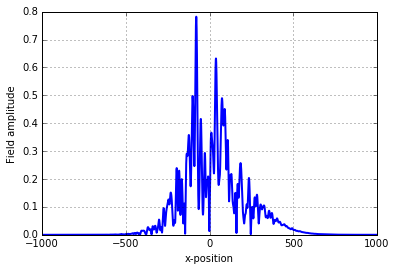

In [4]:
# Sample the beam at the diffuser
beamSample = beam(collGrid.px)

# Propagate the sample back to the focal plane of the telescope
beamSample = simfft.fftPropagate(beamSample, collGrid, -dR)

plt.plot(collGrid.px, np.abs(beamSample), linewidth = 2)
plt.xlim((-1000,1000))
plt.xlabel(r'x-position')
plt.ylabel(r'Field amplitude')
plt.grid(True)
plt.show()

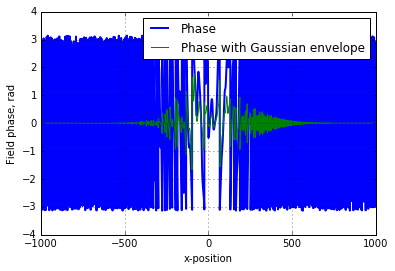

In [5]:
plt.plot(collGrid.px, np.angle(beamSample), linewidth = 2, label ='Phase')
plt.plot(collGrid.px, np.abs(beamSample) / np.max(np.abs(beamSample)) * np.angle(beamSample), label = 'Phase with Gaussian envelope')
plt.xlim((-1000,1000))
plt.ylim((-4, 4))
plt.xlabel(r'x-position')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.legend()
plt.show()

## Create the input field to the MLA's

The MLA inputs are the Fourier transform of this field when the diffuser is in the focal plane of the collimating lens.

In [6]:
scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
inputField    = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beamSample)))

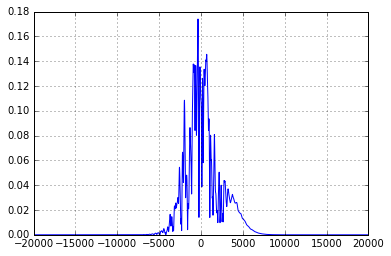

In [7]:
plt.plot(collGrid.pX, np.abs(inputField))
plt.xlim((-20000, 20000))
plt.grid(True)
plt.show()

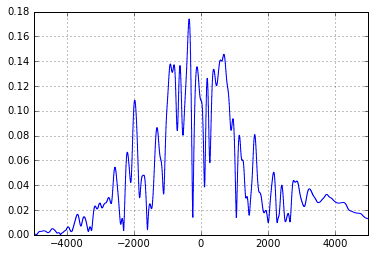

In [8]:
# Interpolate this field onto the MLA grid
mag = np.abs(inputField)
ang = np.angle(inputField)

inputMag = interp1d(collGrid.pX,
                    mag,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)
inputAng = interp1d(collGrid.pX,
                    ang,
                    kind         = 'nearest',
                    bounds_error = False,
                    fill_value   = 0.0)

plt.plot(grid.px, np.abs(inputMag(grid.px) * np.exp(1j * inputAng(grid.px))))
plt.xlim((-5000, 5000))
plt.grid(True)
plt.show()

In [9]:
field2 = lambda x: inputMag(x) * np.exp(1j * inputAng(x))

In [10]:
interpMag, interpAng = simfft.fftSubgrid(field2, grid)

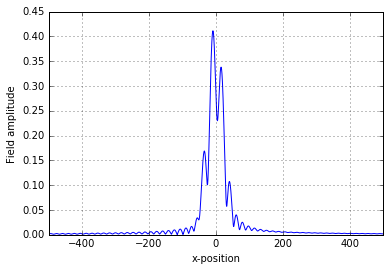

In [11]:
# Plot the field behind the second MLA center lenslet
plt.plot(grid.pX, np.abs(interpMag[10](grid.pX) * np.exp(1j * interpAng[10](grid.pX))))
plt.xlim((-500, 500))
plt.xlabel('x-position')
plt.ylabel('Field amplitude')
plt.grid(True)
plt.show()

## Propagate this field through the dual MLA illuminator
The rest of this code is exactly the same as before: propagate the partially coherent beam through the illuminator and observe the irradiance pattern on the sample.

## Compute many realizations of the diffuser

In [12]:
fObj    = 3300           # microns
bfpDiam = 2 * 1.4 * fObj # microns, BFP diameter, 2 * NA * f_OBJ

L2 = np.array([350000, 400000])

# Grid for interpolating the field after the second MLA
newGridSize = subgridSize * numLenslets # microns
newGrid     = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)

In [13]:
nIter   = 1000

# Create multiple sample irradiance patterns for various values of sigma_r
for currL2 in L2:
       
    # New phase mask; the diffuser sits 'dR' microns from the focus
    beam = lambda x: fields.GaussianBeamDefocused(fieldAmp, beamStd, wavelength, dR)(x) \
                   * fields.diffuserMask(sigma_f, sigma_r, collGrid)(x)
    
    avgIrrad0 = np.zeros(collGrid.px.size, dtype=np.float64)
    avgIrrad1 = np.zeros(grid.px.size, dtype=np.float64)
    avgIrrad2 = np.zeros(newGrid.px.size, dtype=np.float64)
    avgIrrad3 = np.zeros(newGrid.px.size, dtype=np.float64)
    avgIrrad4 = np.zeros(newGrid.pX.size, dtype=np.float64)
    
    for realization in range(nIter):
        print('L2: {0:d}'.format(currL2))
        print('Realization number: {0:d}'.format(realization))

        # Propagate the field from the diffuser to the telescope focus
        beamSample = beam(collGrid.px)
        beamSample = simfft.fftPropagate(beamSample, collGrid, -dR)
        
        avgIrrad0 = avgIrrad0 + np.abs(beamSample)**2 / Z0 * 1000
        
        # Compute the field in the focal plane of the collimating lens
        scalingFactor = collGrid.physicalSize / (collGrid.gridSize - 1) / np.sqrt(collGrid.wavelength * collGrid.focalLength)
        afterColl     = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(beamSample)))
        
        # Interpolate the input onto the new grid;
        # Propagate it to the first MLA at distance L1 away from the focal plane of the collimating lens
        inputMag = interp1d(collGrid.pX,
                            np.abs(afterColl),
                            kind         = 'nearest',
                            bounds_error = False,
                            fill_value   = 0.0)
        inputAng = interp1d(collGrid.pX,
                            np.angle(afterColl),
                            kind         = 'nearest',
                            bounds_error = False,
                            fill_value   = 0.0)
        inputField = lambda x: simfft.fftPropagate(inputMag(x) * np.exp(1j * inputAng(x)), grid, L1)
        
        avgIrrad1 = avgIrrad1 + np.abs(inputField(grid.px))**2 / Z0 * 1000

        # Compute the field magnitude and phase for each individual lenslet just beyond the second MLA
        interpMag, interpPhase = simfft.fftSubgrid(inputField, grid)

        # For each interpolated magnitude and phase corresponding to a lenslet
        # 1) Compute the full complex field
        # 2) Sum it with the other complex fields
        field   = np.zeros(newGrid.gridSize)
        for currMag, currPhase in zip(interpMag, interpPhase):
            fieldMag   = currMag(newGrid.px)
            fieldPhase = currPhase(newGrid.px)

            currField = fieldMag * np.exp(1j * fieldPhase)
            field     = field + currField

        avgIrrad2 = avgIrrad2 + np.abs(field)**2 / Z0 * 1000    
        
        # Propagate the field to the objective's BFP and truncate the region outside the aperture
        field = simfft.fftPropagate(field, newGrid, currL2)
        field[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0
        
        avgIrrad3 = avgIrrad3 + np.abs(field)**2 / Z0 * 1000
            
        # Propagate the truncated field in the BFP to the sample
        scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
        F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(field)))    

        # Compute the irradiance on the sample
        Irrad = np.abs(F)**2 / Z0 * 1000

        # Save the results for this realization
        avgIrrad4 = avgIrrad4 + Irrad

    # Average irradiance
    avgIrrad0 = avgIrrad0 / nIter
    avgIrrad1 = avgIrrad1 / nIter
    avgIrrad2 = avgIrrad2 / nIter
    avgIrrad3 = avgIrrad3 / nIter
    avgIrrad4 = avgIrrad4 / nIter

    # Save the results
    np.save('x-coords0_L2_{0:d}.npy'.format(currL2), collGrid.px)
    np.save('avgIrrad0_L2_{0:d}.npy'.format(currL2), avgIrrad0)
    
    np.save('x-coords1_L2_{0:d}.npy'.format(currL2), grid.px)
    np.save('avgIrrad1_L2_{0:d}.npy'.format(currL2), avgIrrad1)
    
    np.save('x-coords2_L2_{0:d}.npy'.format(currL2), newGrid.px)
    np.save('avgIrrad2_L2_{0:d}.npy'.format(currL2), avgIrrad2)
    
    np.save('x-coords3_L2_{0:d}.npy'.format(currL2), newGrid.px)
    np.save('avgIrrad3_dR_{0:d}.npy'.format(currL2), avgIrrad3)
    
    np.save('x-coords4_L2_{0:d}.npy'.format(currL2), newGrid.pX)
    np.save('avgIrrad4_L2_{0:d}.npy'.format(currL2), avgIrrad4)

L2: 350000
Realization number: 0
L2: 350000
Realization number: 1
L2: 350000
Realization number: 2
L2: 350000
Realization number: 3
L2: 350000
Realization number: 4
L2: 350000
Realization number: 5
L2: 350000
Realization number: 6
L2: 350000
Realization number: 7
L2: 350000
Realization number: 8
L2: 350000
Realization number: 9
L2: 350000
Realization number: 10
L2: 350000
Realization number: 11
L2: 350000
Realization number: 12
L2: 350000
Realization number: 13
L2: 350000
Realization number: 14
L2: 350000
Realization number: 15
L2: 350000
Realization number: 16
L2: 350000
Realization number: 17
L2: 350000
Realization number: 18
L2: 350000
Realization number: 19
L2: 350000
Realization number: 20
L2: 350000
Realization number: 21
L2: 350000
Realization number: 22
L2: 350000
Realization number: 23
L2: 350000
Realization number: 24
L2: 350000
Realization number: 25
L2: 350000
Realization number: 26
L2: 350000
Realization number: 27
L2: 350000
Realization number: 28
L2: 350000
Realization n

In [18]:
# Check the output power
powerOut = simps(avgIrrad4, newGrid.pX)
print('The output power is {0:.2f} mW'.format(powerOut))

The output power is 75.50 mW
